<a href="https://colab.research.google.com/github/rahvlrawat/Spoiler-Alert/blob/main/Spoiler_Alert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports/Installations 

In [4]:
import os

In [5]:
os.system('pip install -q kaggle')
os.system('mkdir ~/.kaggle')
os.system('cp /content/drive/MyDrive/kaggle.json   ~/.kaggle/')
os.system('chmod 600 ~/.kaggle/kaggle.json')
os.system('kaggle datasets download -d  rmisra/imdb-spoiler-dataset')
os.system('kaggle datasets download -d   rtatman/glove-global-vectors-for-word-representation')




0

In [6]:
os.system('unzip  /content/imdb-spoiler-dataset.zip')

256

In [7]:
os.system('unzip /content/glove-global-vectors-for-word-representation.zip')

256

In [8]:
pip install --user -U nltk

Requirement already up-to-date: nltk in /root/.local/lib/python3.6/site-packages (3.5)


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import norm

from datetime import datetime
import re
from wordcloud import WordCloud, STOPWORDS

from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

from sklearn import svm

import re
import nltk
from nltk.corpus import stopwords


# Data Preprocessing

In [10]:
df_reviews = pd.read_json('/content/IMDB_reviews.json', lines=True)
df_details = pd.read_json('/content/IMDB_movie_details.json', lines=True)


In [11]:
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [12]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [13]:
df_reviews.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'rating', 'review_summary'],
      dtype='object')

In [14]:
df_details.columns

Index(['movie_id', 'plot_summary', 'duration', 'genre', 'rating',
       'release_date', 'plot_synopsis'],
      dtype='object')

In [15]:
df=pd.merge(df_reviews,df_details,on='movie_id')

In [16]:
df.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'rating_x', 'review_summary', 'plot_summary', 'duration', 'genre',
       'rating_y', 'release_date', 'plot_synopsis'],
      dtype='object')

In [17]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."


In [18]:
df.rename(columns = {'rating_x':'userrating','rating_y':'actualrating'}, inplace = True)

In [19]:
df['is_spoiler']=df['is_spoiler']+0

In [20]:
df["review_date"]=pd.to_datetime(df["review_date"])
df["release_date"]=pd.to_datetime(df["release_date"])
df["days_elapsed"]=abs(df["review_date"]-df["release_date"]).dt.days

In [21]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed
0,2006-02-10,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137
1,2000-09-06,tt0111161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2154
2,2001-08-03,tt0111161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2485
3,2002-09-01,tt0111161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2879
4,2004-05-20,tt0111161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",3506


# Exploratory Analysis
 


In [22]:
df.dtypes

review_date       datetime64[ns]
movie_id                  object
user_id                   object
is_spoiler                 int64
review_text               object
userrating                 int64
review_summary            object
plot_summary              object
duration                  object
genre                     object
actualrating             float64
release_date      datetime64[ns]
plot_synopsis             object
days_elapsed               int64
dtype: object

In [23]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed
0,2006-02-10,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137
1,2000-09-06,tt0111161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2154
2,2001-08-03,tt0111161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2485
3,2002-09-01,tt0111161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2879
4,2004-05-20,tt0111161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",3506


In [24]:
print('Total no. of reviews:' , len(df))

Total no. of reviews: 573906


In [25]:
print("Total no. of users who gave reviews:",df['user_id'].nunique() )

Total no. of users who gave reviews: 263404


In [26]:
print('Total films in dataset :', df['movie_id'].nunique())

Total films in dataset : 1570


Distribution of rating across all movie reviews:


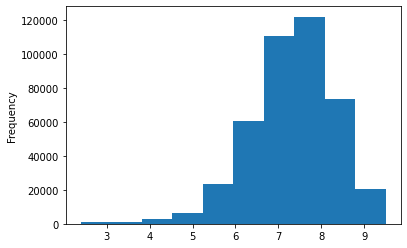

In [27]:
print("Distribution of rating across all movie reviews:")
df[df["is_spoiler"]==0]['actualrating'].plot(kind='hist')

Distribution of rating across all movie reviews:


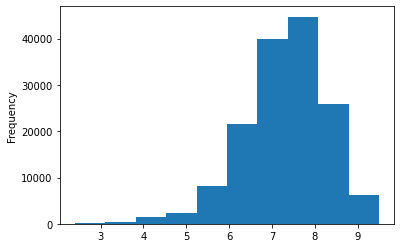

In [28]:
print("Distribution of rating across all movie reviews:")
df[df["is_spoiler"]==1]['actualrating'].plot(kind='hist')

Most of the ratings are concentrated around 6-9  for both reviews either containing spoiler or not.

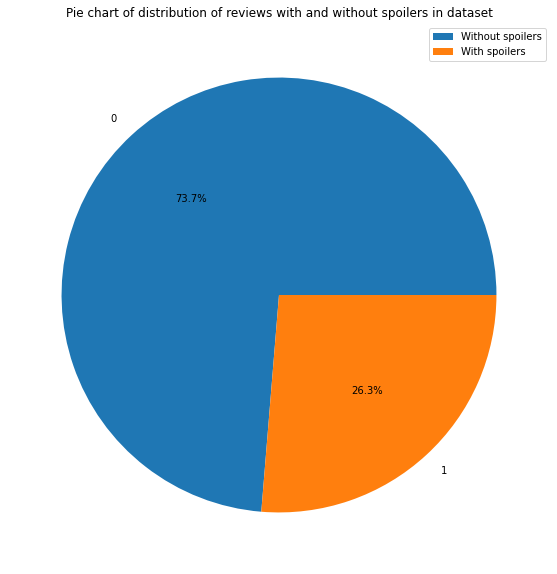

In [29]:
labels, frequencies = np.unique(df.is_spoiler.values,return_counts = True)
plt.figure(figsize = (10,10))
x=plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title('Pie chart of distribution of reviews with and without spoilers in dataset')
plt.legend(labels=['Without spoilers', 'With spoilers'])

Text(0.5, 1.0, 'Pie chart for reviews for top 10 genres:')

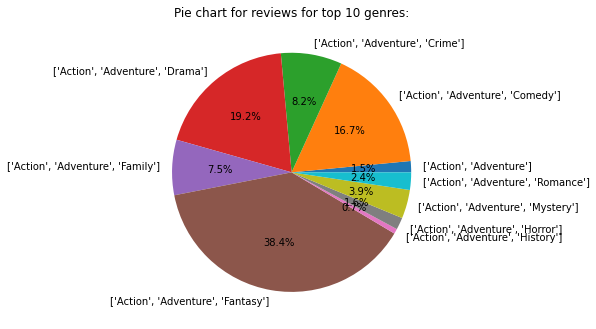

In [30]:
labels, frequencies = np.unique(df.genre.values,return_counts = True)
plt.figure(figsize = (8,8))
x=plt.pie(frequencies[:10],labels = labels[:10], autopct = '%1.1f%%')
plt.tight_layout()
plt.title('Pie chart for reviews for top 10 genres:')

These are the top 10 genre sets with most spoiler reviews.

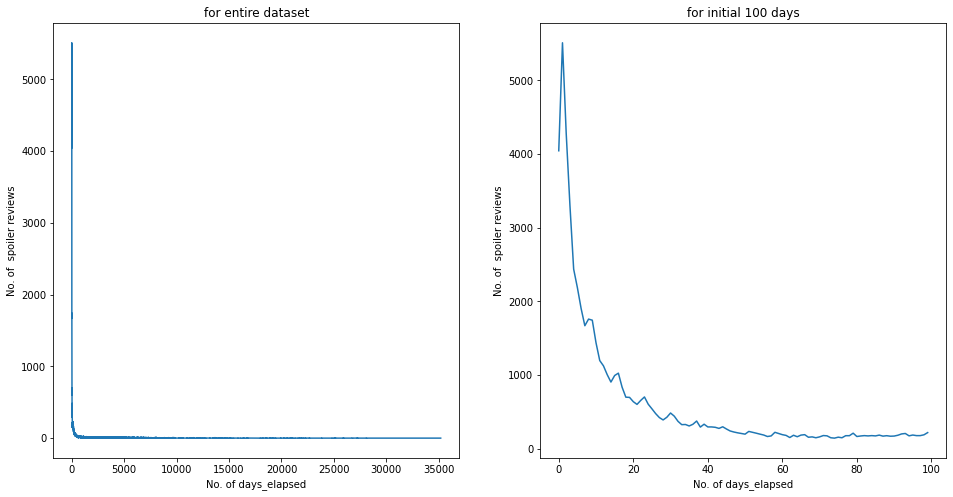

In [31]:
df_temp=df[["is_spoiler","days_elapsed"]]
df_temp=df_temp.groupby(['is_spoiler', 'days_elapsed']).size().reset_index(name='count').sort_values('days_elapsed')

fig = plt.figure(figsize=(16, 8))


ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(df_temp[df_temp["is_spoiler"]==1]["days_elapsed"].values,df_temp[df_temp["is_spoiler"]==1]["count"].values)
ax1.set_title('for entire dataset')
ax1.set_xlabel('No. of days_elapsed')
ax1.set_ylabel('No. of  spoiler reviews')

ax2.plot(df_temp[df_temp["is_spoiler"]==1]["days_elapsed"][:100].values,df_temp[df_temp["is_spoiler"]==1]["count"][:100].values)
ax2.set_xlabel('No. of days_elapsed')
ax2.set_title('for initial 100 days')
ax2.set_ylabel('No. of  spoiler reviews')

plt.show()

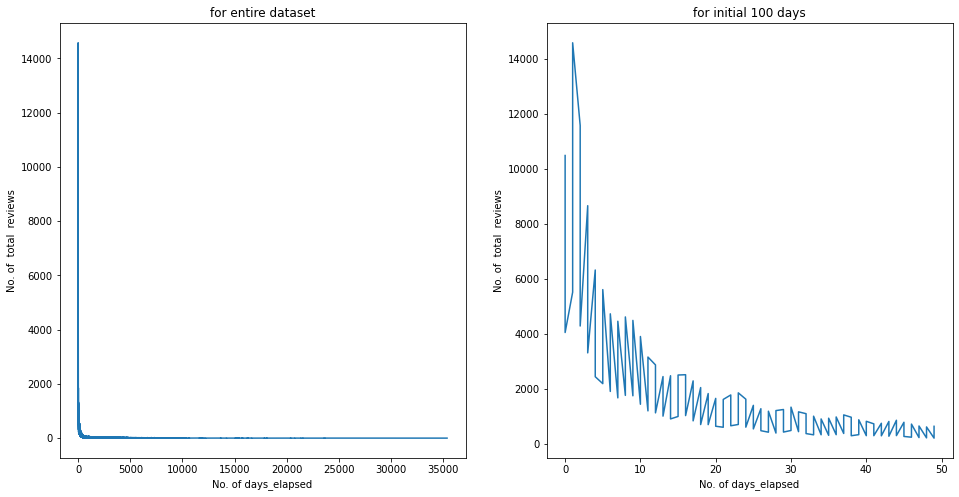

In [32]:
fig = plt.figure(figsize=(16, 8))


ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(df_temp["days_elapsed"].values,df_temp["count"].values)
ax1.set_title('for entire dataset')
ax1.set_xlabel('No. of days_elapsed')
ax1.set_ylabel('No. of  total  reviews')

ax2.plot(df_temp["days_elapsed"][:100].values,df_temp["count"][:100].values)
ax2.set_xlabel('No. of days_elapsed')
ax2.set_title('for initial 100 days')
ax2.set_ylabel('No. of  total  reviews')

plt.show()

As can be seen from above set of graphs that most of the reviews occur around the release date of the movie and with time the reviews corresponding to the  movie get lesser and lesser and thus reviews have as evident from graphs the tendency to contain spoilers more if they are near the release date.

In [33]:
print("Top 10 Movies with most spoilers")
print(df[df['is_spoiler']==1].movie_id.value_counts()[:10])


Top 10 Movies with most spoilers
tt0468569    1482
tt0111161     956
tt0167260     490
tt2488496     482
tt0137523     459
tt0068646     420
tt1446714     400
tt0110912     397
tt1300854     390
tt1074638     366
Name: movie_id, dtype: int64


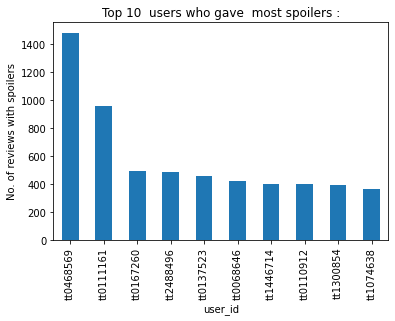

In [34]:
df[df['is_spoiler']==1].movie_id.value_counts()[:10].plot.bar()
plt.title("Top 10  users who gave  most spoilers :")
plt.xlabel('user_id')
plt.ylabel('No. of reviews with spoilers')
plt.show()

In [35]:
print("Top 10 Users with most spoilers")
print(df[df['is_spoiler']==1].user_id.value_counts()[:10])

Top 10 Users with most spoilers
ur4248714     1019
ur60028700     767
ur5291991      540
ur7813355      503
ur22668817     473
ur2079400      454
ur2707735      441
ur45215448     422
ur13977076     417
ur1697212      415
Name: user_id, dtype: int64


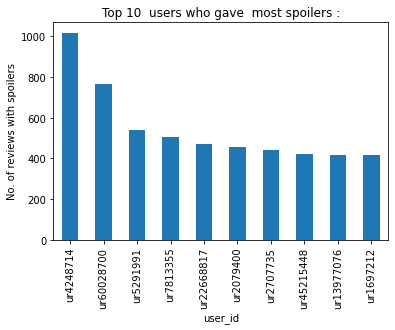

In [36]:
df[df['is_spoiler']==1].user_id.value_counts()[:10].plot.bar()
plt.title("Top 10  users who gave  most spoilers :")
plt.xlabel('user_id')
plt.ylabel('No. of reviews with spoilers')
plt.show()

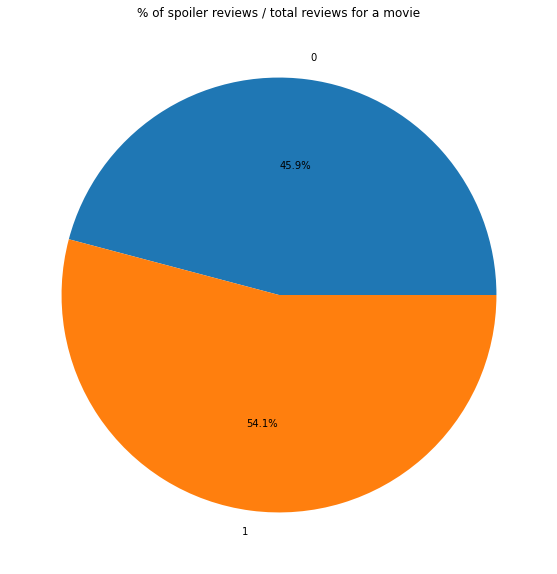

In [37]:
labels, frequencies = np.unique(df[df['movie_id']=='tt1446714'].is_spoiler.values,return_counts = True)
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title("% of spoiler reviews / total reviews for a movie")
plt.show()

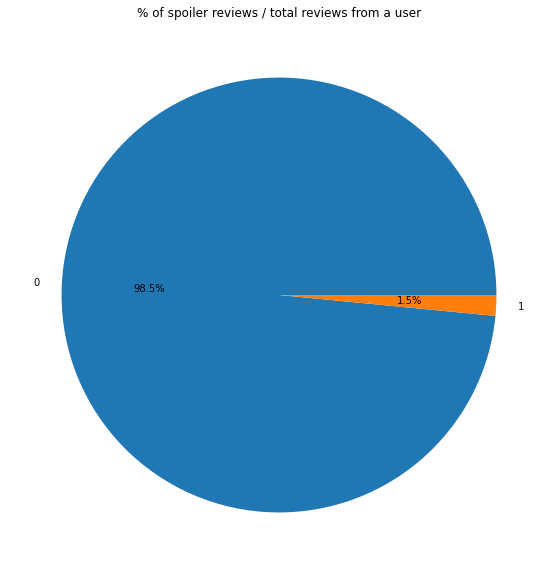

In [38]:
labels, frequencies = np.unique(df[df['user_id']=='ur2898520'].is_spoiler.values,return_counts = True)
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title("% of spoiler reviews / total reviews from a user")
plt.show()

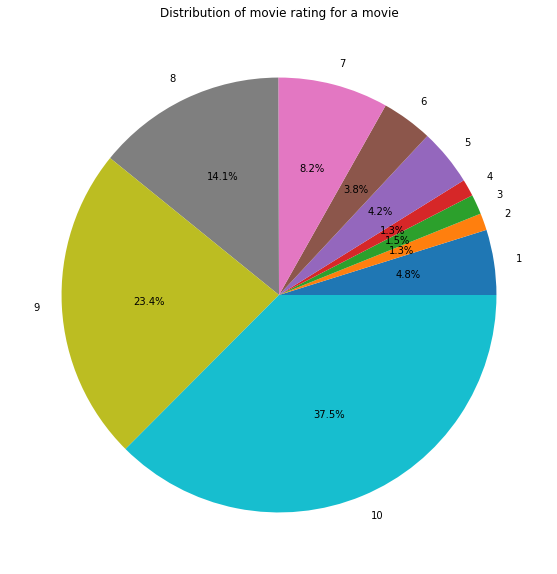

In [39]:
labels, frequencies = np.unique(df[df['movie_id']=='tt1291584'].userrating.values,return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title("Distribution of movie rating for a movie")
plt.show()

In [40]:
df['user_id'].value_counts()[:5]

ur2898520     1303
ur4248714     1021
ur0453068      806
ur60028700     770
ur20552756     755
Name: user_id, dtype: int64

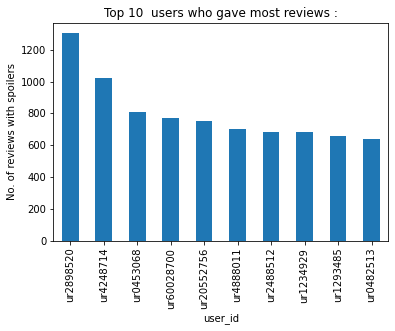

In [41]:
df['user_id'].value_counts()[:10].plot.bar()
plt.title("Top 10  users who gave most reviews :")
plt.xlabel('user_id')
plt.ylabel('No. of reviews with spoilers')
plt.show()

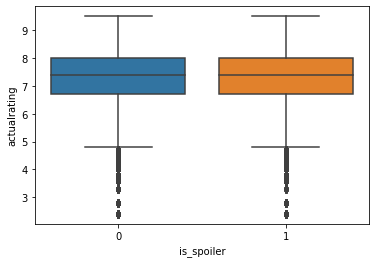

In [42]:

sns.boxplot(x= df.is_spoiler,y=df.actualrating)


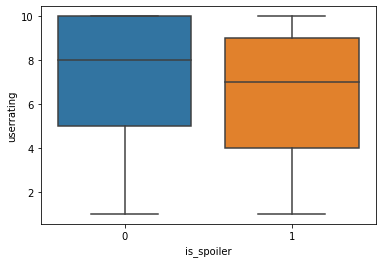

In [43]:
sns.boxplot(x= df.is_spoiler,y=df.userrating)

# Movie spoiler ratio(MSR)

In [44]:
total_spoilers= df.groupby(by='movie_id').is_spoiler.agg(['sum']).reset_index().rename(columns={'sum':'total_spoilers'})

In [45]:
total_movies = df.groupby(by='movie_id').movie_id.agg(['count']).reset_index().rename(columns={'count':'total_movies'})

In [46]:
msr = pd.merge(total_spoilers,total_movies, on='movie_id')

In [47]:
msr['msr']=msr.total_spoilers/msr.total_movies

In [48]:
msr.head()

,movie_id,total_spoilers,total_movies,msr
0,tt0012349,26,104,0.250000
1,tt0015864,39,128,0.304688
2,tt0017136,73,337,0.216617
3,tt0017925,50,192,0.260417
4,tt0018455,63,178,0.353933


In [49]:
msr.drop(['total_spoilers','total_movies'], axis=1, inplace=True)

In [50]:
df=pd.merge(df,msr,on='movie_id')

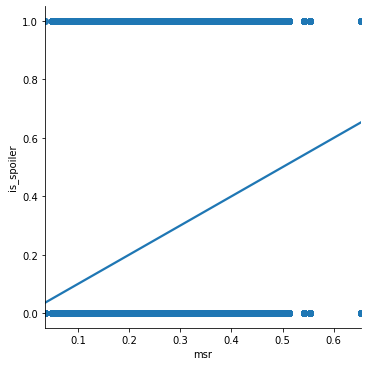

In [51]:
sns.lmplot(x ="msr", y ="is_spoiler", data = df, order = 2, ci = None) 

#User Spoiler Ratio (USR)

In [52]:
total_user_spoilers = df.groupby(by='user_id').is_spoiler.agg(['sum']).reset_index().rename(columns={'sum':'total_user_spoilers'})


In [53]:
total_users = df.groupby(by='user_id').user_id.agg(['count']).reset_index().rename(columns={'count':'total_users'})


In [54]:
usr = pd.merge(total_user_spoilers,total_users, on='user_id')

In [55]:
usr['usr']=usr.total_user_spoilers / usr.total_users

In [56]:
usr.drop(['total_user_spoilers','total_users'], axis=1,inplace=True)

In [57]:
df= pd.merge(df, usr, on='user_id')

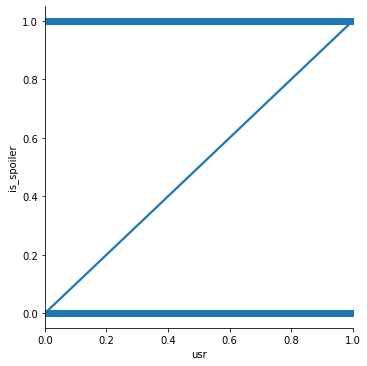

In [58]:
sns.lmplot(x ="usr", y ="is_spoiler", data = df, order = 2, ci = None) 

# Some Genres tend to have more spoilers

<h2>Some genre categories combined together will produce more spoilers so our goal is to segregate those particular genre category combos and use them to predict if movie can have spoiler review or not</h2>

In [59]:
genres= np.unique(np.array(' '.join(df.genre.str.join(' ')).split()))

In [60]:
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western'], dtype='<U9')

In [61]:
genre_df=pd.DataFrame()

In [62]:
for i in genres:
    genre_df[i.lower()]=0

In [63]:
c=0

In [64]:
df.isnull()

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,msr,usr
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
573902,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
573903,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
573904,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [65]:
for i,data in df_details.iterrows():
    #Assigns details pertaining to a movie to a variable
    details=df_details[df_details.movie_id==data['movie_id']]
    genre_df.at[i,'movie_id']=data['movie_id']
    for genre in genres:
        #Checks if movie belongs to the genre or not 
        genre_df.at[i,genre.lower()]=int(genre in details['genre'].tolist()[0])

In [66]:
genre_df.head()

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,film-noir,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western,movie_id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,tt0105112
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tt1204975
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,tt0243655
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,tt0040897
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,tt0126886


In [67]:
df_temp= pd.merge(df, genre_df, on="movie_id")

In [68]:
df_temp.head()

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,msr,usr,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,film-noir,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western
0,2006-02-10,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137,0.219216,0.600000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000-09-06,tt0111161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2154,0.219216,0.250000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2001-08-03,tt0111161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2485,0.219216,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2002-09-01,tt0111161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2879,0.219216,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2004-05-20,tt0111161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",3506,0.219216,0.135714,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
df_temp.shape

(573906, 37)

In [70]:
e = 0.001
gsr = np.zeros(len(genres))
for i,g in enumerate(genres):
    # i.e. total no. of reviews with spoiler belonging to a genre /total no. of reviews of movie genre
    gsr[i] = df_temp[(df_temp.is_spoiler==1) &
                                     (df_temp[g.lower()]==1)].shape[0] / (df_temp[df_temp[g.lower()]==1].shape[0]
                                                                          +e)

In [71]:
gsr

array([0.28260197, 0.28689807, 0.25694626, 0.24139909, 0.2156022 ,
       0.24629342, 0.25653166, 0.27053262, 0.28138213, 0.27247333,
       0.23578351, 0.29666125, 0.20991318, 0.20297205, 0.28947245,
       0.23652655, 0.31211931, 0.23998089, 0.28114596, 0.24305825,
       0.25500944])

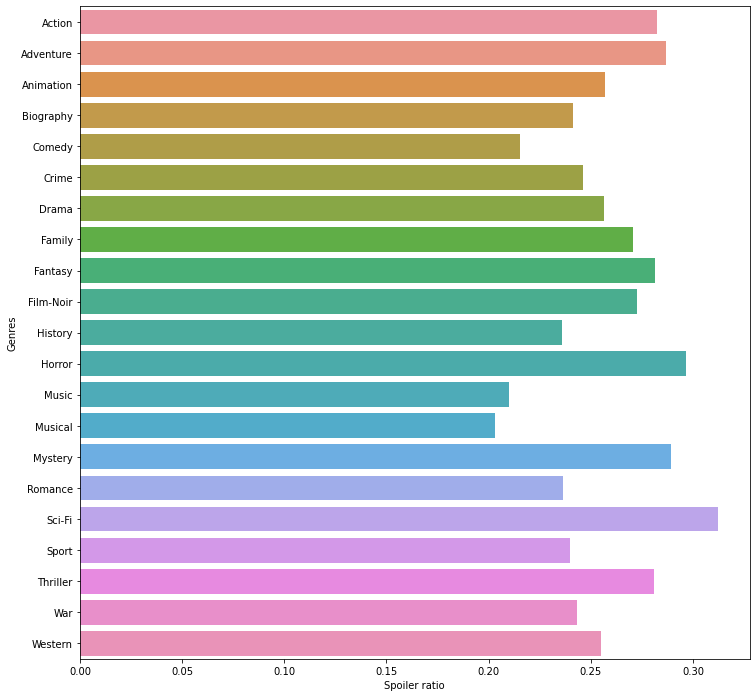

In [72]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x=gsr,y=genres)
ax.set(xlabel="Spoiler ratio",ylabel="Genres");
plt.show();

<h2> Calculating spoiler ratio for combination of genres (GSR)</h2>

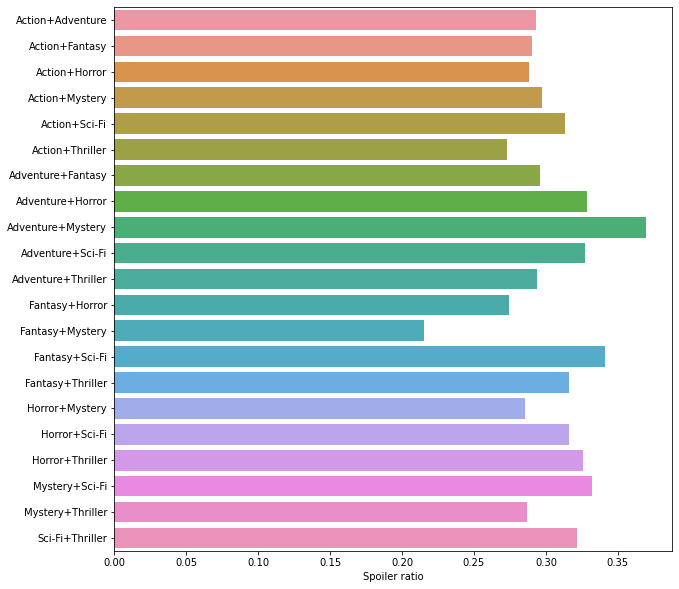

In [73]:
e = 0.001
selected = ["Action","Adventure","Fantasy","Horror","Mystery","Sci-Fi","Thriller"]

genre2 = []
genre2ratios = []

i=0
while i < len(selected):
    j = i+1
    while j < len(selected):
        # i.e. ratio of total movies reviews having spoilers belonging to selected genres / total reviews of the movies of selected genres
        genre2.append(selected[i]+"+"+selected[j])
        spoilers = df_temp[(df_temp[selected[i].lower()]==1) & (df_temp[selected[j].lower()]==1) & df_temp.is_spoiler].shape[0]
        total = df_temp[(df_temp[selected[i].lower()]==1) & (df_temp[selected[j].lower()]==1)].shape[0]
        genre2ratios.append(spoilers / (total+e))
        j+=1
    i+=1
plt.figure(figsize=(10,10))    
ax = sns.barplot(x=genre2ratios,y=genre2)
ax.set(xlabel="Spoiler ratio");
plt.show();

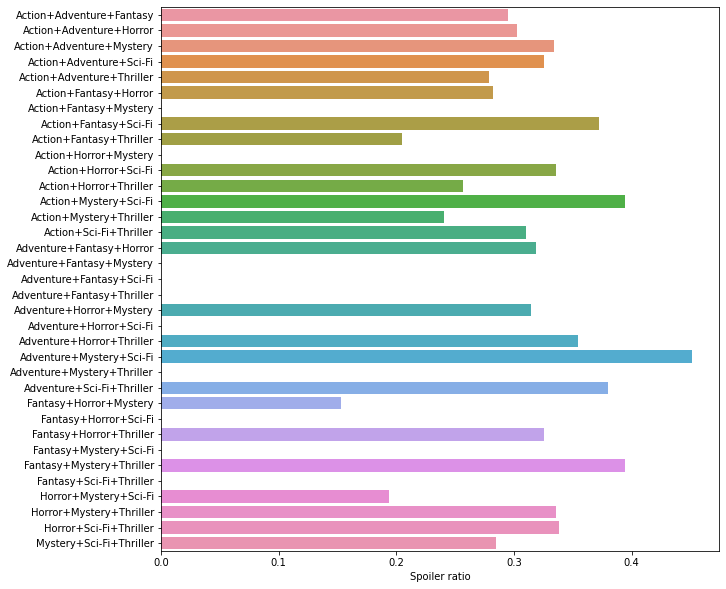

In [74]:
genre3= []
genre3ratios = []

i=0
while i < len(selected):
    j = i+1
    while j < len(selected):
        k = j+1
        while k < len(selected):
            genre3.append(selected[i]+"+"+selected[j]+"+"+selected[k])
            spoilers = df_temp[(df_temp[selected[k].lower()]==1) & (df_temp[selected[i].lower()]==1) & (df_temp[selected[j].lower()]==1) & df_temp.is_spoiler].shape[0]
            total = df_temp[(df_temp[selected[k].lower()]==1) & (df_temp[selected[i].lower()]==1) & (df_temp[selected[j].lower()]==1)].shape[0]
            genre3ratios.append(spoilers / (total+e))
            k+=1
        j+=1
    i+=1
    
plt.figure(figsize=(10,10))
ax = sns.barplot(x=genre3ratios,y=genre3)
ax.set(xlabel="Spoiler ratio");
plt.show();

In [75]:
def isListSubset(a,b):
    count = 0
    for i,v in enumerate(a):
        if v in b:
            count += 1
    return count == len(a)

def getGenreRatio(genres):
    return isListSubset(["Fantasy","Sci-Fi"], genres) or isListSubset(["Adventure","Mystery"], genres) or isListSubset(["Action","Mystery","Sci-Fi"], genres) or isListSubset(["Adventure","Horror","Thriller"], genres) or isListSubset(["Adventure","Thriller"], genres) or isListSubset(["Fantasy","Mystery"], genres)

In [76]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [77]:
df['gsr'] = pd.merge(df,df_details.drop(['genre'],axis=1),on="movie_id").genre.apply(getGenreRatio)+0

In [78]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,msr,usr,gsr
0,2006-02-10,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137,0.219216,0.6,0
1,2006-03-19,tt0144084,ur1898687,0,"Starring: Christian Bale, Willem Dafoe, Chloë ...",8,"Worth seeing, if only for the post-viewing dis...","Patrick Bateman is handsome, well educated and...",1h 42min,"[Crime, Drama]",7.6,2000-04-14,A white background. Red drops begin to fall pa...,2165,0.274725,0.6,0
2,2006-02-10,tt0298203,ur1898687,1,"Eminem's ""semi-autobiographical"" rap movie. Do...",7,Better than it needed to be.,This is the inspiring captivating story of the...,1h 50min,"[Drama, Music]",7.1,2002-11-08,"It's 1995. Jimmy ""B-Rabbit"" Smith Jr. (Eminem)...",1190,0.164456,0.6,0
3,2006-02-10,tt0319061,ur1898687,0,The grass is so green / The sky is so blue / S...,9,An immediate classic that works on both a visu...,United Press International journalist Will Blo...,2h 5min,"[Adventure, Drama, Fantasy]",8.0,2004-01-09,"Edward Bloom (Albert Finney), a charismatic te...",763,0.158416,0.6,0
4,2006-02-10,tt0377092,ur1898687,1,There are a few signs heading into Mean Girls ...,7,"A smart, but flawed, look at high school life","Her parents being zoologists, homeschooled Cad...",1h 37min,[Comedy],7.0,2004-04-30,Cady (Lindsay Lohan) is the 16-year-old home-s...,651,0.222472,0.6,0


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:256: RankWarning: Polyfit may be poorly conditioned
  yhat = reg_func(x, y)


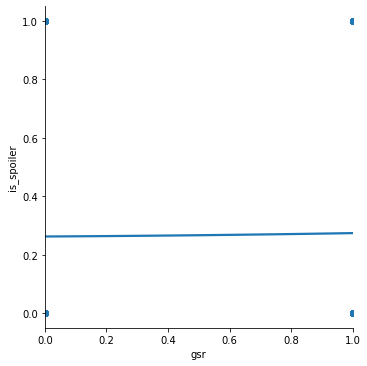

In [79]:
sns.lmplot(x ="gsr", y ="is_spoiler", data = df, order = 2, ci = None) 

# Spoiler Text in review 

In [80]:
df[df.review_text.str.contains('SPOILERS')]

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,msr,usr,gsr
10,2002-09-01,tt0111161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2879,0.219216,0.5,0
14,2002-02-13,tt0088247,ur1003471,1,***MINOR SPOILERS AHEAD***There's been so much...,8,"Simple idea, perfect realization",A cyborg is sent from the future on a deadly m...,1h 47min,"[Action, Sci-Fi]",8.0,1984-10-26,Over an apocalyptic battlefield in the year 20...,6319,0.261261,0.5,0
16,2002-02-15,tt0240772,ur1003471,1,"***MINOR SPOILERS***Soderbergh goes Vegas!OK, ...",8,Start spreading the news...,Danny Ocean wants to score the biggest heist i...,1h 56min,"[Crime, Thriller]",7.8,2001-12-07,"Daniel Ocean (George Clooney), a convicted thi...",70,0.134935,0.5,0
17,2003-01-13,tt0217505,ur1003471,1,***SPOILERS HO!***Before I start I'd like to s...,4,The cat in the hat comes back. Why?,Having seen his father killed in a major gang ...,2h 47min,"[Crime, Drama]",7.5,2002-12-20,The film opens with Priest Vallon (Liam Neeson...,24,0.171322,0.5,0
19,2002-04-19,tt0286499,ur1003471,1,** MINOR SPOILERS **This film is like that epi...,4,The best British women's football film since G...,A comedy about bending the rules to reach your...,1h 52min,"[Comedy, Drama, Romance]",6.7,2003-08-01,"Jesminder ""Jess"" Bhamra (Parminder Nagra) is t...",469,0.100946,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572748,2001-09-14,tt0182789,ur1354522,1,***SPOILERS*** ***SPOILERS*** The movie did ...,10,Asimov's 3 laws of robotics are the central th...,This film follows the 'life' and times of the ...,2h 12min,"[Comedy, Drama, Sci-Fi]",6.8,1999-12-17,"The NDR series robot ""Andrew"" is introduced in...",637,0.203636,1.0,0
572749,2002-07-25,tt0182789,ur1288887,1,"SPOILERS BEWARE!!!!\nI am late.. But, I just s...",10,Awesome movie. Very touching.,This film follows the 'life' and times of the ...,2h 12min,"[Comedy, Drama, Sci-Fi]",6.8,1999-12-17,"The NDR series robot ""Andrew"" is introduced in...",951,0.203636,1.0,0
572926,2001-10-03,tt0171804,ur1359036,1,***SPOILERS*** ***SPOILERS*** ***SPOILERS*...,10,A tragic masterpiece,Based on actual events. Brandon Teena is the p...,1h 58min,"[Biography, Crime, Drama]",7.6,2000-03-31,The film opens with Brandon Teena (Hilary Swan...,551,0.161074,1.0,0
573140,2001-06-30,tt0140352,ur1242481,1,***SPOILERS*** ***SPOILERS*** Having taken t...,10,"If only all films were this cinematic, this en...","Balls-out ""60 Minutes"" producer Lowell Bergman...",2h 37min,"[Biography, Drama, Thriller]",7.9,1999-11-05,"In Lebanon, Hezbollah militants escort produce...",603,0.082687,1.0,0


In [81]:
df['spoiltext'] = df.review_text.str.contains('SPOILERS')+0

In [82]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,msr,usr,gsr,spoiltext
0,2006-02-10,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137,0.219216,0.6,0,0
1,2006-03-19,tt0144084,ur1898687,0,"Starring: Christian Bale, Willem Dafoe, Chloë ...",8,"Worth seeing, if only for the post-viewing dis...","Patrick Bateman is handsome, well educated and...",1h 42min,"[Crime, Drama]",7.6,2000-04-14,A white background. Red drops begin to fall pa...,2165,0.274725,0.6,0,0
2,2006-02-10,tt0298203,ur1898687,1,"Eminem's ""semi-autobiographical"" rap movie. Do...",7,Better than it needed to be.,This is the inspiring captivating story of the...,1h 50min,"[Drama, Music]",7.1,2002-11-08,"It's 1995. Jimmy ""B-Rabbit"" Smith Jr. (Eminem)...",1190,0.164456,0.6,0,0
3,2006-02-10,tt0319061,ur1898687,0,The grass is so green / The sky is so blue / S...,9,An immediate classic that works on both a visu...,United Press International journalist Will Blo...,2h 5min,"[Adventure, Drama, Fantasy]",8.0,2004-01-09,"Edward Bloom (Albert Finney), a charismatic te...",763,0.158416,0.6,0,0
4,2006-02-10,tt0377092,ur1898687,1,There are a few signs heading into Mean Girls ...,7,"A smart, but flawed, look at high school life","Her parents being zoologists, homeschooled Cad...",1h 37min,[Comedy],7.0,2004-04-30,Cady (Lindsay Lohan) is the 16-year-old home-s...,651,0.222472,0.6,0,0


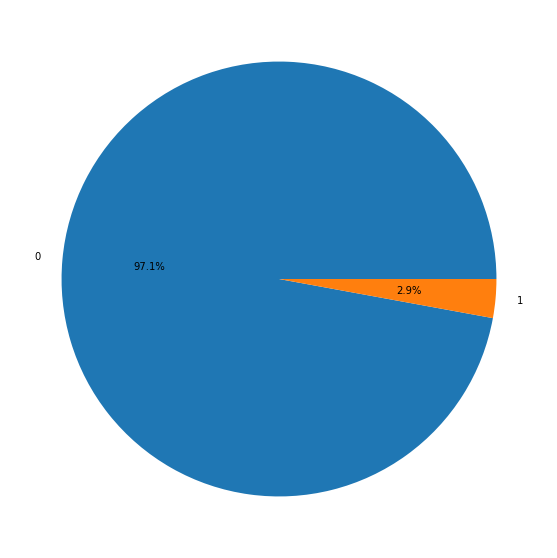

In [83]:
labels, frequencies = np.unique(df[df['is_spoiler']==1].spoiltext.values,return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

#  Matching Text from reviews with plot summary


Comparing the similarity of spoiler reviews to movie plot summary will be a good indicator as to if a review contains spoiler or not 

In [84]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
stopwords=set(stopwords.words('english'))

In [86]:
len(stopwords)

179

In [87]:
stopwords_dict=Counter(stopwords)

In [88]:
def preprocesstext(review):
    review=review.lower()
    review=re.sub('[^a-zA-Z]',' ',review)
    words=review.split()
    word=[word for word in words if word not in stopwords_dict]
    review=" ".join(words)
    return review

In [89]:
df.review_text=df.review_text.apply(preprocesstext)

In [90]:
df.review_text

0         in its oscar year shawshank redemption written...
1         starring christian bale willem dafoe chlo sevi...
2         eminem s semi autobiographical rap movie do i ...
3         the grass is so green the sky is so blue spect...
4         there are a few signs heading into mean girls ...
                                ...                        
573901    i think this movie was under appreciated by am...
573902    this type of movie is one that i would not ord...
573903    go is wise fast and pure entertainment assembl...
573904    go is the best movie i have ever seen and i ve...
573905    why was this movie made no doubt to sucker in ...
Name: review_text, Length: 573906, dtype: object

Using glove-global-vectors for words.These pre-trained embeddings are used  to quantify word co-occurrence (which also captures some aspects of word meaning). This dataset contains 50-dimensional, 100-dimensional and 200-dimensional pre trained word vectors

In [91]:
#Saving the words and their corresponding vectors in  a dictionary
embeddings=dict()
f=open('/content/glove.6B.50d.txt')
for i in f: 
    values=i.split()
    word=values[0]
    cofss = np.asarray(values[1:], dtype='float32')
    embeddings[word]=cofss
f.close()    

In [92]:
def getAvgWordEmbedding(text):
    words = text.split()
    n = 0
    sumEmbed = np.zeros(50)
    # because 50 dim of word vectors
    
    for word in words:
        if word in embeddings:
            sumEmbed += embeddings[word]
            n += 1
    
    avgEmbed = sumEmbed / n
    return avgEmbed
    
def Dist(e1, e2):
    return np.sum(np.square(e1-e2), axis = 1)

In [93]:
df_details.plot_summary

0       Former CIA analyst, Jack Ryan is in England wi...
1       Billy (Michael Douglas), Paddy (Robert De Niro...
2       The setting is Camp Firewood, the year 1981. I...
3       Fred C. Dobbs and Bob Curtin, both down on the...
4       Tracy Flick is running unopposed for this year...
                              ...                        
1567    Evan Treborn grows up in a small town with his...
1568    Brandon is a 30-something man living in New Yo...
1569    Evacuation of Allied soldiers from the British...
1570    For a while now, beautiful 24-year-old Diana B...
1571    The marriage of David Burgess, a senior execut...
Name: plot_summary, Length: 1572, dtype: object

In [94]:
plot_embed = df.plot_summary.apply(getAvgWordEmbedding)
review_embed = df.review_text.apply(getAvgWordEmbedding)

In [95]:
distance=Dist(np.stack(review_embed),np.stack(plot_embed))

In [96]:
df['distance']=distance

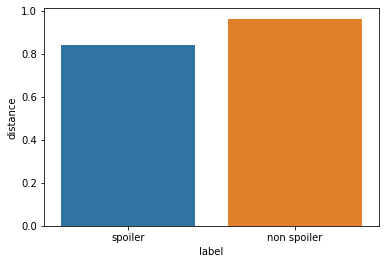

In [97]:
df_temp = pd.DataFrame({"label":["spoiler", "non spoiler"], 
                        "distance":[df[df.is_spoiler==1].distance.mean(), 
                                        df[df.is_spoiler==0].distance.mean()]})
sns.barplot(x = "label", y = "distance", data = df_temp);

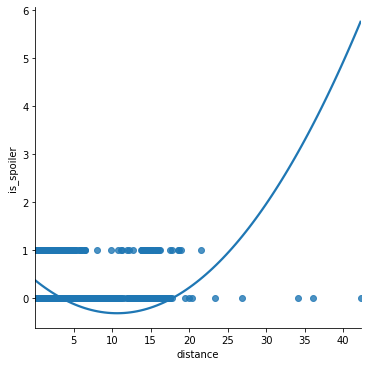

In [98]:
sns.lmplot(x ="distance", y ="is_spoiler", data = df, order = 2, ci = None) 

As can be seen from all the above new dimensions introduced we don't have a single  criteria to distinguish between spoiler and non spoiler reviews  but its dependent a no. of criterias  so in order to solve this problem we will now look into a way to unify all these criterias using machine learning to help us in separating non spoiler reviews from spoiler reviews.


# Saving the processed dataset for future use


In [99]:
#df.to_csv('/content/drive/MyDrive/Spoiler_alert_model/processed_data/processed_data.csv',index=False)

#Preparing  Triain / Valid / Test Sets


In [97]:
spoilers = df[df.is_spoiler == 1].sample(frac=1).reset_index(drop=True)
notspoilers = df[df.is_spoiler == 0].sample(frac=1).reset_index(drop=True)

In [98]:
len(spoilers),len(notspoilers)

(150924, 422982)

In [99]:
# train set
train = pd.concat([spoilers.head(100000), notspoilers.head(100000)]).sample(frac=1).reset_index(drop=True)

# test set
test = pd.concat([spoilers.tail(50000), notspoilers.tail(100000)]).sample(frac=1).reset_index(drop=True)

In [101]:
train.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'userrating', 'review_summary', 'plot_summary', 'duration', 'genre',
       'actualrating', 'release_date', 'plot_synopsis', 'days_elapsed', 'msr',
       'usr', 'gsr', 'spoiltext', 'distance'],
      dtype='object')

In [205]:
x_train = train[['msr','usr','gsr','distance','spoiltext','actualrating']]
x_train= x_train.fillna(0).values

In [206]:
y_train=train['is_spoiler'].values

In [194]:
x_train.shape

(200000, 7)

In [195]:
test.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'userrating', 'review_summary', 'plot_summary', 'duration', 'genre',
       'actualrating', 'release_date', 'plot_synopsis', 'days_elapsed', 'msr',
       'usr', 'gsr', 'spoiltext', 'distance'],
      dtype='object')

In [207]:
x_test = test[['msr','usr','gsr','distance','spoiltext','actualrating']]
x_test = x_test.fillna(0).values

In [208]:
y_test=test['is_spoiler']
y_test=y_test.values

# Linear Regression 

In [198]:
from sklearn.linear_model import LogisticRegression

In [209]:
linear= LogisticRegression() 
linear.fit(x_train, y_train) 
print(linear.score(x_test, y_test))

0.91526


In [210]:
linearpredstrain=linear.predict(x_train)
print(classification_report(y_train, linearpredstrain))
print(confusion_matrix(y_train, linearpredstrain))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91    100000
           1       0.92      0.89      0.91    100000

    accuracy                           0.91    200000
   macro avg       0.91      0.91      0.91    200000
weighted avg       0.91      0.91      0.91    200000

[[92607  7393]
 [10747 89253]]


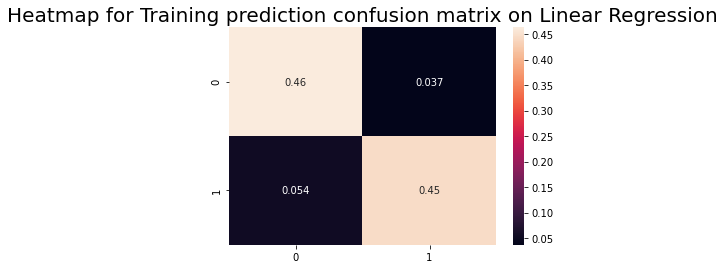

In [140]:
plt.title("Heatmap for Training prediction confusion matrix on Linear Regression", fontsize =20)
sns.heatmap(confusion_matrix(y_train, linearpredstrain)/np.sum(confusion_matrix(y_train, linearpredstrain)), annot=True)

In [202]:
linearpredstest=linear.predict(x_test)

In [203]:
print(classification_report(y_test, linearpredstest))
print(confusion_matrix(y_test, linearpredstest))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94    100000
           1       0.86      0.89      0.87     50000

    accuracy                           0.91    150000
   macro avg       0.90      0.91      0.90    150000
weighted avg       0.92      0.91      0.92    150000

[[92767  7233]
 [ 5540 44460]]


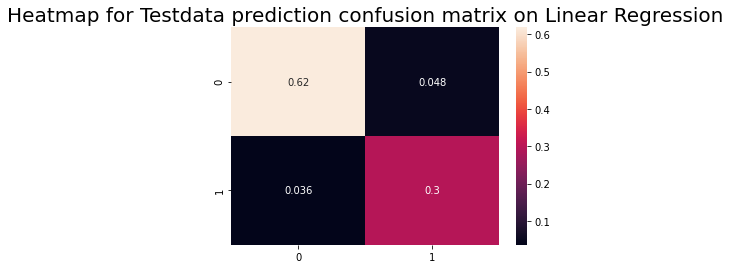

In [141]:
plt.title("Heatmap for Testdata prediction confusion matrix on Linear Regression", fontsize =20)
sns.heatmap(confusion_matrix(y_test, linearpredstest)/np.sum(confusion_matrix(y_test, linearpredstest)), annot=True)

# Using Linear svm model for  training  using the newly created dimensions for the reviews which more aptly represent the data



In [112]:
model_svm= svm.SVC(kernel='linear')
model_svm.fit(x_train, y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [176]:
print(model_svm.score(x_test, y_test))

0.9129


In [123]:
svmpredstrain = model_svm.predict(x_train)

In [124]:
print(classification_report(y_train, svmpredstrain))
print(confusion_matrix(y_train, svmpredstrain))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91    100000
           1       0.91      0.91      0.91    100000

    accuracy                           0.91    200000
   macro avg       0.91      0.91      0.91    200000
weighted avg       0.91      0.91      0.91    200000

[[91441  8559]
 [ 9173 90827]]


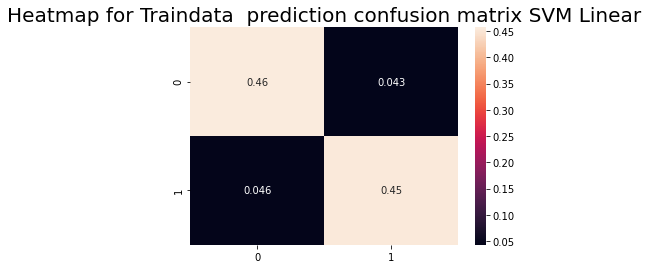

In [174]:
plt.title("Heatmap for Traindata  prediction confusion matrix SVM Linear", fontsize =20)
sns.heatmap(confusion_matrix(y_train, svmpredstrain)/np.sum(confusion_matrix(y_train, svmpredstrain)), annot=True)

In [125]:
svmpredstest = model_svm.predict(x_test)

In [126]:
print(classification_report(y_test, svmpredstest))
print(confusion_matrix(y_test, svmpredstest))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93    100000
           1       0.84      0.91      0.87     50000

    accuracy                           0.91    150000
   macro avg       0.90      0.91      0.90    150000
weighted avg       0.92      0.91      0.91    150000

[[91590  8410]
 [ 4655 45345]]


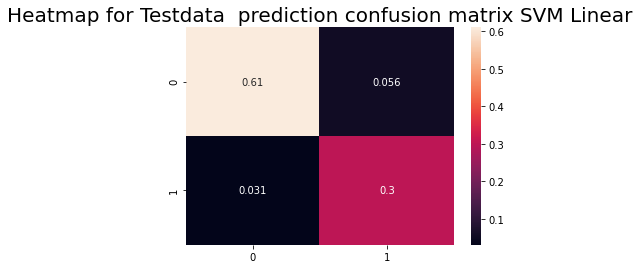

In [173]:
plt.title("Heatmap for Testdata  prediction confusion matrix SVM Linear", fontsize =20)
sns.heatmap(confusion_matrix(y_test, svmpredstest)/np.sum(confusion_matrix(y_test, svmpredstest)), annot=True)

#Tweaking Hyperparameters of SVM for training

In [177]:
model_svm_rdf = svm.SVC(gamma='scale',C=10)
model_svm_rdf.fit(x_train, y_train)


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [178]:
print(model_svm_rdf.score(x_test, y_test))

0.9105666666666666


In [179]:
rdfpredstrain = model_svm_rdf.predict(x_train)

In [180]:
print(classification_report(y_train, rdfpredstrain))
print(confusion_matrix(y_train, rdfpredstrain))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91    100000
           1       0.91      0.92      0.91    100000

    accuracy                           0.91    200000
   macro avg       0.91      0.91      0.91    200000
weighted avg       0.91      0.91      0.91    200000

[[90539  9461]
 [ 8000 92000]]


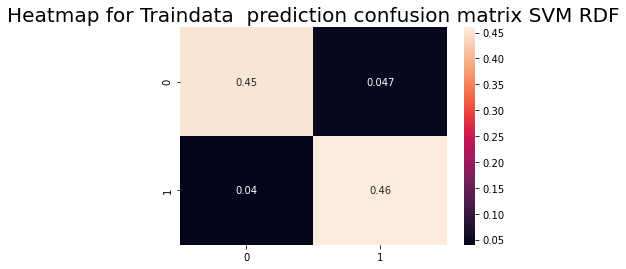

In [181]:
plt.title("Heatmap for Traindata  prediction confusion matrix SVM RDF", fontsize =20)
sns.heatmap(confusion_matrix(y_train, rdfpredstrain)/np.sum(confusion_matrix(y_train, rdfpredstrain)), annot=True)

In [182]:
rdfpredstest = model_svm_rdf.predict(x_test)  

In [183]:
print(classification_report(y_test, rdfpredstest))
print(confusion_matrix(y_test, rdfpredstest))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93    100000
           1       0.83      0.92      0.87     50000

    accuracy                           0.91    150000
   macro avg       0.89      0.91      0.90    150000
weighted avg       0.92      0.91      0.91    150000

[[90644  9356]
 [ 4059 45941]]


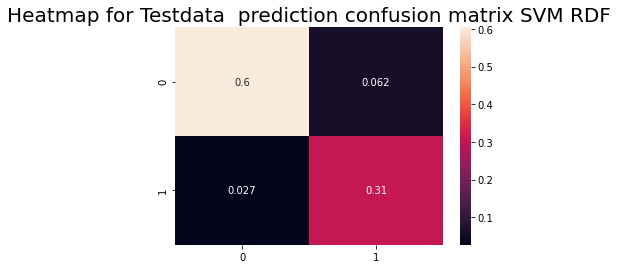

In [184]:
plt.title("Heatmap for Testdata  prediction confusion matrix SVM RDF", fontsize =20)
sns.heatmap(confusion_matrix(y_test, rdfpredstest)/np.sum(confusion_matrix(y_test, rdfpredstest)), annot=True)

# Saving and Loading the Model 

In [185]:
filename = '/content/drive/MyDrive/Spoiler_alert_model/Spoiler_alert.sav'


In [187]:
import pickle

In [188]:
pickle.dump(linear, open(filename, 'wb'))

In [189]:
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


In [190]:
result = loaded_model.score(x_test, y_test)
print(result)

0.91526


In [ ]:
loaded_model.predict()

# Appendix


for application main columns needed are   [userid,movieid,review_text,userrating,actualrating,plot_synopsis]
rest all columns such as [msr,usr,gsr,spoiltext,distance]  are then  build from this existing info  using  code given below  in a modified manner
and then finally ['msr','usr','gsr','distance','spoiltext','actualrating'] these cols are passed to model for getting a prediction 

In [ ]:
#If used train_test_split earlier for randomly sampled data from entire dataset add these pramas just as we did while training

# test0 = pd.merge(test, usr, how = 'left', on = 'user_id')
# test0 = pd.merge(test0, msr, how = 'left', on = 'movie_id')
# test0['gsr'] = test0.genre.apply(getGenreRatio)+0
# test0.review_text = test0.review_text.apply(preprocesstext)
# review_embed_test = test.review_text.apply(getAvgWordEmbedding)
# plot_embed_test = test.plot_summary.apply(getAvgWordEmbedding)
# test0['distance'] = Dist(np.stack(review_embed_test), np.stack(plot_embed_test))
#test0['spoiltext'] = test0.review_summary.str.contains('SPOILERS')+0